# Further Data Processing and Exploratory Data Analysis

Link to notebook: https://colab.research.google.com/drive/1IVGhswcju1ZUc2SNBf1pMXd-cZerdzOi?usp=sharing

In this notebook we do additional data cleaning and processing required for the Exploratory Data Analysis. We then created visualisations from the data to better understand the dataset.

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import re

import contractions
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from numpy import *
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Reading the data

In [ ]:
# This cell reads files from Google Colab. If not using Colab, change the file directories accordingly
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/Datasets/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/test_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df.shape

(39658, 2)

In [ ]:
test_df.shape

(9915, 2)

In [ ]:
merged_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)
merged_df.shape

(49573, 2)

In [ ]:
merged_df.head()

,Text,Sentiment
0,i saw this when it premiered and just re-watch...,8
1,this movie is one of my all-time favorites. i ...,6
2,describing stalingrad as a war film may be a b...,8
3,"""tale of two sisters"" has to be one of the cre...",8
4,"well, i notice imdb has not offered any plot i...",1


## Splitting data into positive and negative sentiments

In [ ]:
merged_df['Sentiment'].value_counts()

Sentiment
1    9976
8    9666
6    5840
4    5282
3    4903
5    4786
7    4583
2    4537
Name: count, dtype: int64

In [ ]:
# Function to convert ratings to binary
def good_bad(data):
    if data <= 4:
        return 0
    else:
        return 1

In [ ]:
merged_df['good_bad'] = merged_df['Sentiment'].apply(good_bad)
merged_df.head()

,Text,Sentiment,good_bad
0,i saw this when it premiered and just re-watch...,8,1
1,this movie is one of my all-time favorites. i ...,6,1
2,describing stalingrad as a war film may be a b...,8,1
3,"""tale of two sisters"" has to be one of the cre...",8,1
4,"well, i notice imdb has not offered any plot i...",1,0


In [ ]:
pos_df = merged_df[merged_df['good_bad'] == 1]
pos_df = pos_df.drop(columns = ['good_bad'])
pos_df.head()

,Text,Sentiment
0,i saw this when it premiered and just re-watch...,8
1,this movie is one of my all-time favorites. i ...,6
2,describing stalingrad as a war film may be a b...,8
3,"""tale of two sisters"" has to be one of the cre...",8
5,this little picture succeeds where many a big ...,7


In [ ]:
neg_df = merged_df[merged_df['good_bad'] == 0]
neg_df = neg_df.drop(columns = ['good_bad'])
neg_df.head()

,Text,Sentiment
4,"well, i notice imdb has not offered any plot i...",1
7,"wow. not because of the 3-d imagery, which at ...",2
11,"i respect alex cox the filmmaker, i really do....",4
12,unhinged was part of the video nasty censorshi...,3
17,'rise of the footsoldier' follows the unrelent...,4


## Further preparation of data for EDA

Remove punctuation marks

In [ ]:
def remove_punctuation(text):
    punctuation_pattern = re.compile(r'[^\w\s]')
    clean_text = punctuation_pattern.sub('', text)
    return clean_text

In [ ]:
pos_df['Text'] = pos_df['Text'].apply(lambda z: remove_punctuation(z))
neg_df['Text'] = neg_df['Text'].apply(lambda z: remove_punctuation(z))

Tokenization

In [ ]:
tokenizer = TweetTokenizer()
pos_df['Text'] = pos_df['Text'].apply(tokenizer.tokenize)
neg_df['Text'] = neg_df['Text'].apply(tokenizer.tokenize)

Stopword Removal

In [ ]:
# Just to check list of stopwords to ensure that the keep tokens isnt redunat
stop_words = set(stopwords.words('english'))
print(stop_words)

{'so', 'your', 'our', 'wasn', 'm', 'himself', 'under', 'each', 'hasn', "it's", 's', 'at', 'doesn', 'has', 'wouldn', 'such', 'who', 'up', 'some', 'before', 'between', 'is', "won't", 'a', 'needn', "haven't", 'that', 'from', 'did', 're', 'how', 'won', 'mustn', 'when', 'these', 'ain', "couldn't", 'more', 've', 'haven', "hadn't", 'been', 'it', 'nor', "you'd", 'be', 'she', "isn't", 'ma', 'am', 'those', 'but', 'or', 'didn', "she's", 'over', "didn't", "that'll", 'what', 'o', "mightn't", 'same', 'below', 'other', "hasn't", 'ourselves', 'the', 'off', 'where', 'should', 'now', 'you', "aren't", "should've", 'don', "doesn't", 'hers', 'whom', 'once', 'their', 'than', "mustn't", 'here', 'through', 'down', 'can', 'does', 'on', 'all', 'had', 'them', 'couldn', 'will', 'because', 'during', "weren't", 'we', "you're", 'again', 'herself', 'very', "shouldn't", 'have', "wasn't", "shan't", 'this', 'doing', 'was', 'shouldn', "needn't", 'yours', 'there', 'myself', 'shan', 'which', 'y', 'both', 'just', 'about', '

In [ ]:
def filter_tokens(tokens):
    stop_words = set(stopwords.words('english'))

    #Our n-grams analysis has shown that the <br> tag was not removed properly
    stop_words.add('br')

    #Based on our analysis, we keep these words in the text as they could correlate to sentiment
    keep_in_tokens = [
        "isn't", "is",
        "wasn't", "was",
        "aren't", "are",
        "doesn't", "does",
        "couldn't", "could",
        "won't", "will",
        "shouldn't", "should",
        "didn't", "did",
        "haven't", "have"
    ]
    for word in keep_in_tokens:
        stop_words.discard(word)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

In [ ]:
pos_df['Text'] = pos_df['Text'].apply(filter_tokens)
neg_df['Text'] = neg_df['Text'].apply(filter_tokens)

Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

In [ ]:
pos_df['Text'] = pos_df['Text'].apply(lemmatize_tokens)
neg_df['Text'] = neg_df['Text'].apply(lemmatize_tokens)

In [ ]:
print("Deep cleaned Positive Dataset")
pos_df.head(10)

Deep cleaned Positive Dataset


,Text,Sentiment
0,saw premiered rewatched ifc is great telling m...,8
1,movie is one alltime favorite think sean penn ...,6
2,describing stalingrad war film may bit inaccur...,8
3,tale two sister one creepiest film have seen r...,8
5,little picture succeeds many big picture fails...,7
6,will love child saddest movie have ever seen d...,8
8,24 is best television show is incredible tv se...,8
9,wa moved film 1981 went back theater four time...,8
10,have recently went back watched movie seeing y...,7
13,watching next action star reality tv series wa...,5


In [ ]:
print("Deep cleaned Negative Dataset")
neg_df.head(10)

Deep cleaned Negative Dataset


,Text,Sentiment
4,well notice imdb offered plot infothat is is p...,1
7,wow 3d imagery time wa used nicely provide goo...,2
11,respect alex cox filmmaker really is like kid ...,4
12,unhinged wa part video nasty censorship film s...,3
17,rise footsoldier follows unrelentingly cruel j...,4
18,vowed time ago never get another joe castro fi...,4
20,yah know name sinatra title bad well is bad tr...,2
25,is far one worst movie have ever seen poor spe...,1
26,saw movie circa 1979 became first movie ever w...,1
30,rented movie noticed cover video rental store ...,4


## Data visualisation

Visualise word cloud

In [ ]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    stop_words.add('br')

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

Positive Movie Review Word Cloud

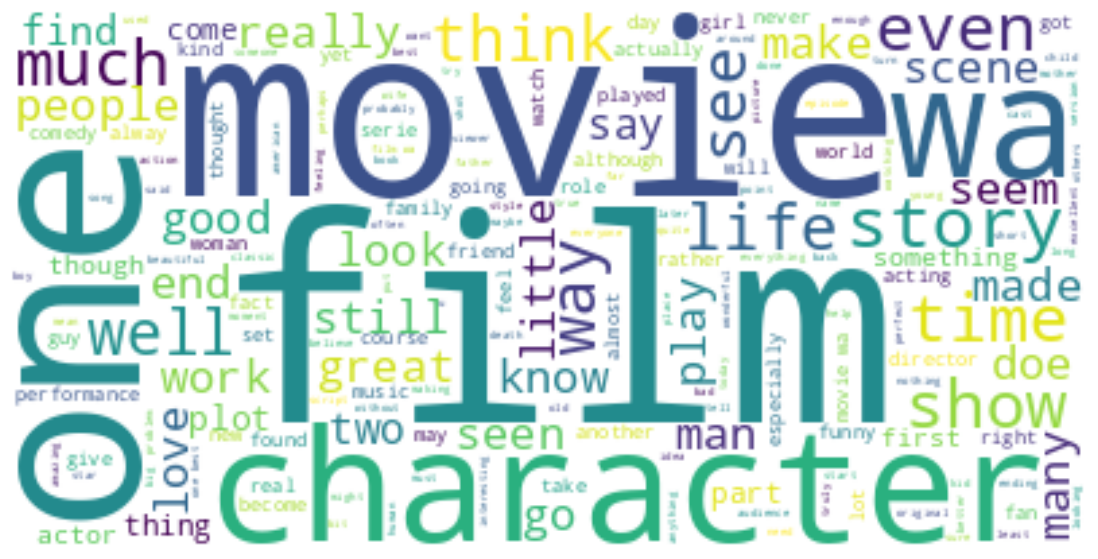

In [ ]:
pos = pos_df.Text
pos_text = " ".join(review for review in pos.astype(str))
pos_wcloud=generate_wcloud(pos_text)

Negative Movie Review Word Cloud

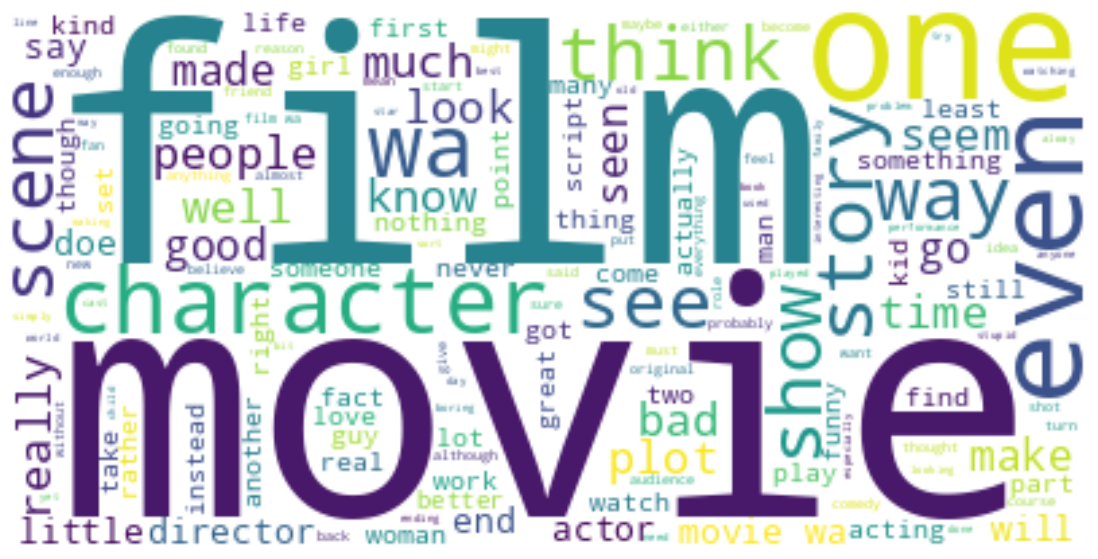

In [ ]:
neg = neg_df.Text
neg_text = " ".join(review for review in neg.astype(str))
neg_wcloud=generate_wcloud(neg_text)

## N-gram analyis on text

N-gram plot function

In [ ]:
def plot_top_ngrams(text, range, top_n=10, title='Top N-grams'):
    """
    Analyze and plot the top N n-grams in a given text.

    Parameters:
    - text: The text to analyze, as a single string.
    - ngram_range: A tuple (min_n, max_n) specifying the range of n-grams to consider.
    - top_n: The number of top n-grams to display.
    - title: The title of the plot.
    """

    vectorizer = CountVectorizer(ngram_range=range)
    X = vectorizer.fit_transform([text])
    ngram_vocab = vectorizer.get_feature_names_out()
    ngram_counts = X.toarray().flatten()
    ngram_dict = dict(zip(ngram_vocab, ngram_counts))
    top_ngrams = sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    ngram_words, ngram_counts = zip(*top_ngrams)

    # Plot the top n-grams
    plt.figure(figsize=(12, 6))
    plt.barh(ngram_words, ngram_counts)
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

Top Trigrams

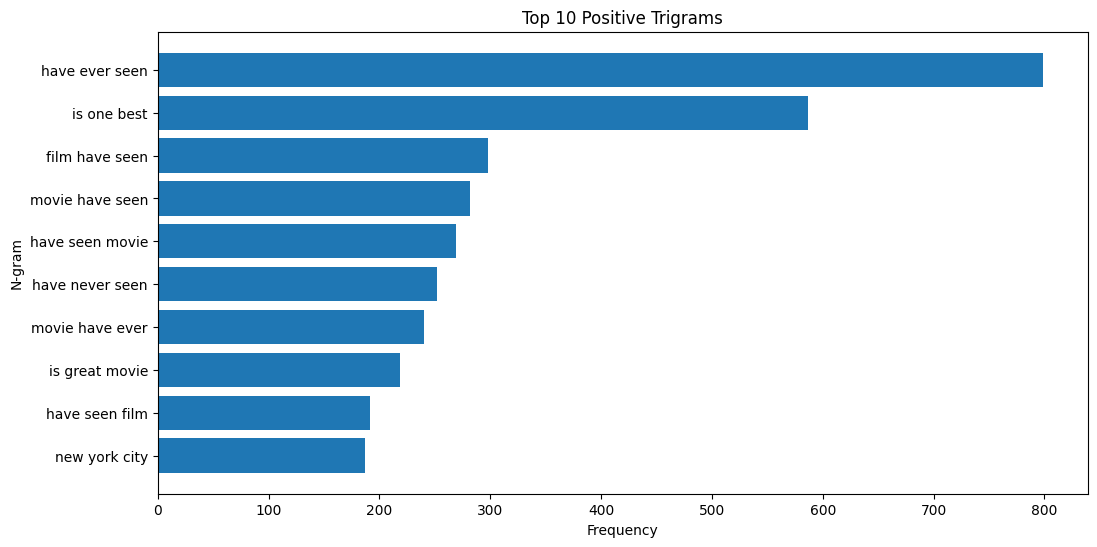

In [ ]:
range = (3,3)
plot_top_ngrams(pos_text, range, top_n=10, title='Top 10 Positive Trigrams')

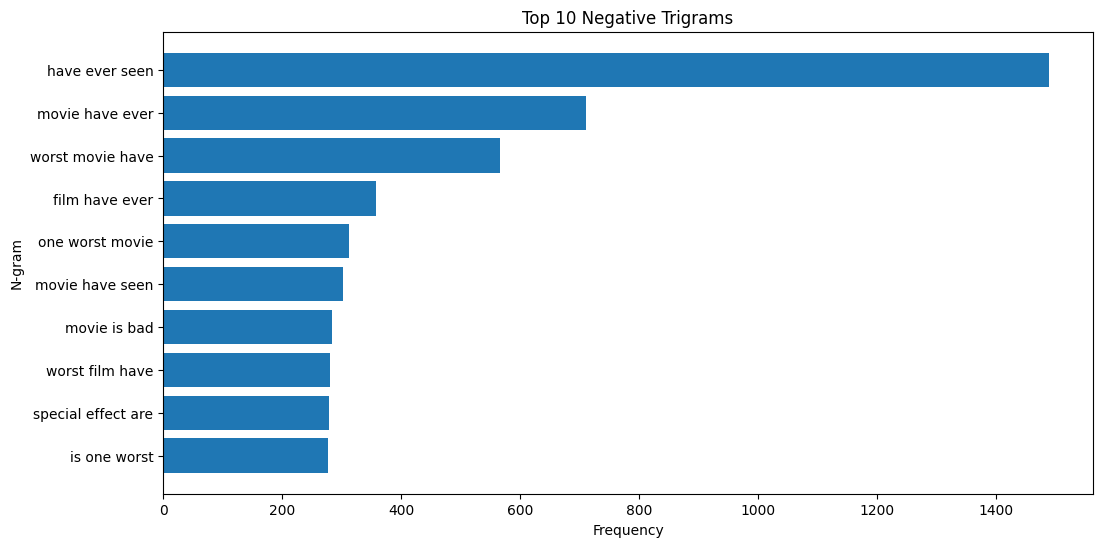

In [ ]:
range = (3,3)
plot_top_ngrams(neg_text, range, top_n=10, title='Top 10 Negative Trigrams')

Top bigrams

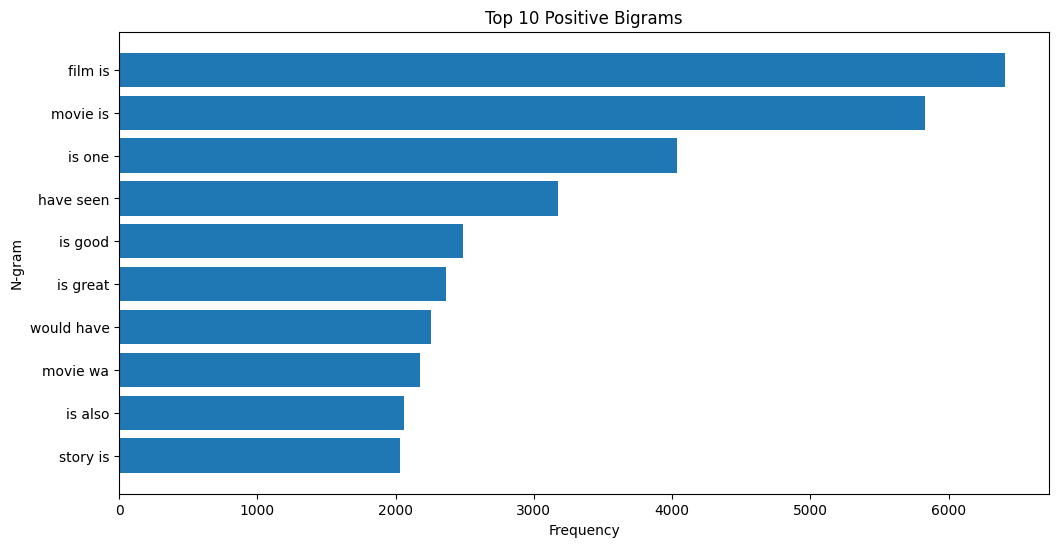

In [ ]:
range = (2,2)
plot_top_ngrams(pos_text, range, top_n=10, title='Top 10 Positive Bigrams')

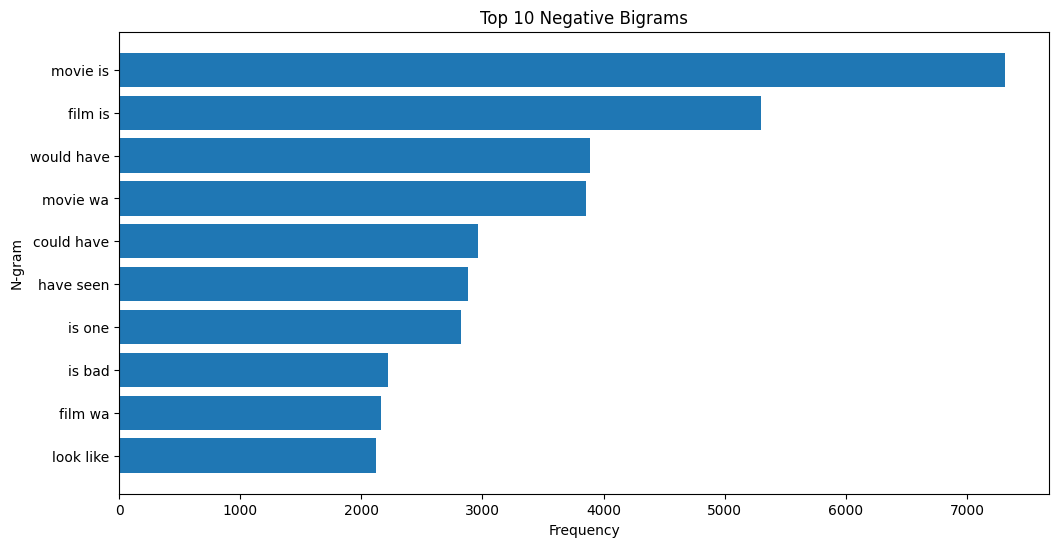

In [ ]:
range = (2,2)
plot_top_ngrams(neg_text, range, top_n=10, title='Top 10 Negative Bigrams')

## Most Frequent Words

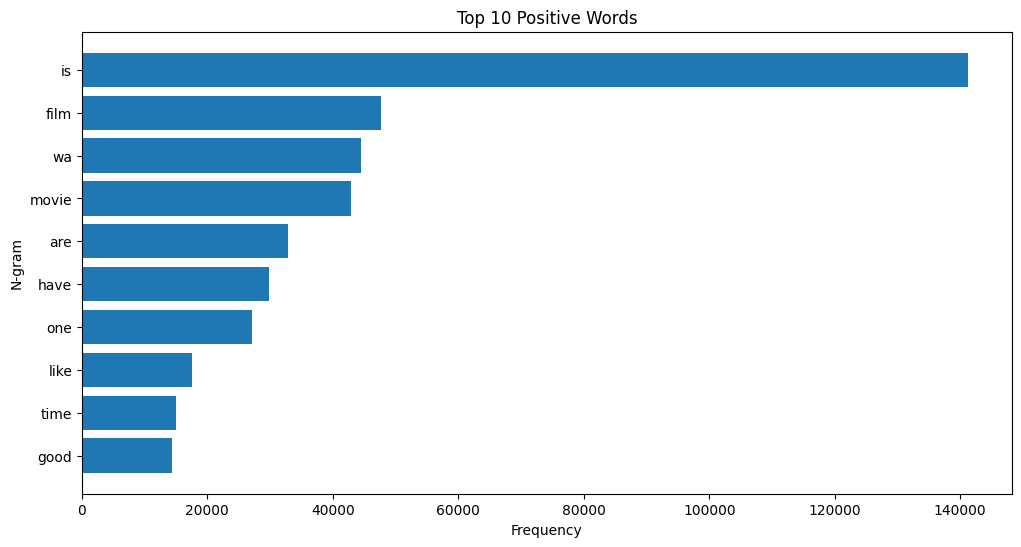

In [ ]:
range = (1,1)
plot_top_ngrams(pos_text, range, top_n=10, title='Top 10 Positive Words')

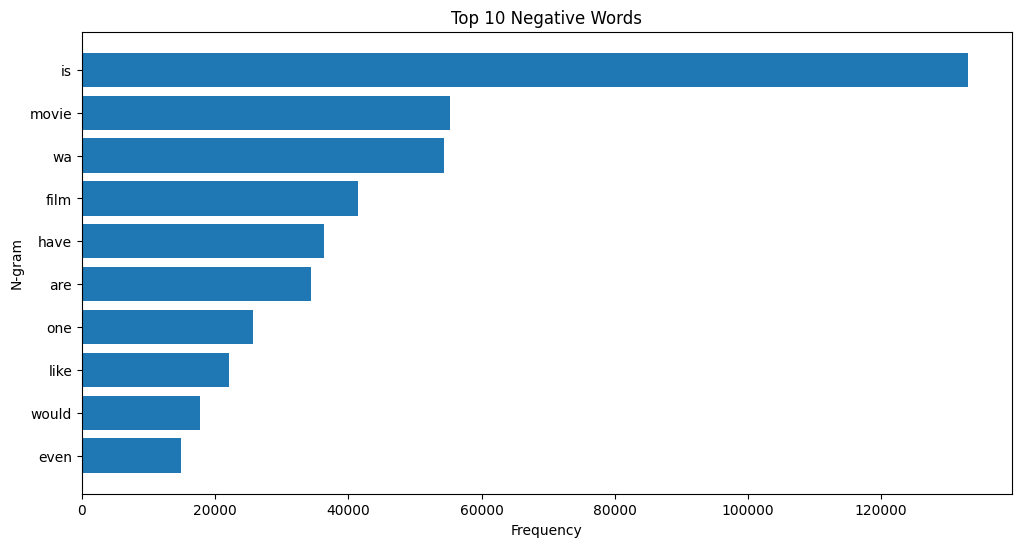

In [ ]:
range = (1,1)
plot_top_ngrams(neg_text, range, top_n=10, title='Top 10 Negative Words')